# Defining Spread Function
The spread function heuristic is defined as indicated in the original ANS paper (https://arxiv.org/abs/1311.2540).

## Definition

$N_s := \left\{ \frac{1}{2p_s} + \frac{i}{p_s} : i \in \mathbb{N} \right\}$

> "These n sets are uniformly distributed with required densities, but they get out of $\N$ set - to define ANS we need to shift them there, like in Fig. 9. Specifically, to choose a symbol for the succeeding position, we can take the smallest not used element from $N_1, .., N_n$ sets."

> - Jarek Duda - Asymmetric numeral systems: entropy coding combining speed of Huffman coding with compression rate of arithmetic coding

## Functions
### `generate_N_s_i`
This function generates the $N_{s_i}$ set for a given probability, `p_s`, and index, `i`

### `generate_N_s`
This function generates the $N_s$ set for a given probability, `p_s`, and length, `l`.

### `generate_N`
This function generates the $N$ set for a given probability distribution, `prob`, and length, `l`.

### `generate_N_iter`
This function generates the $N$ set for a given probability distribution, `prob`, and length, `l`. It then returns an iterator that can be used to generate the $N$ set one element at a time, in ascending order, with each element being of the form, $(N_{s_{cur}}, s)$


In [28]:
class SpreadFunction:
    @staticmethod
    def generate_N_s_i(p_s, i):
        """Generates the value of N_s_i according to the original paper.
           N_s_i = 1/(2*p_s) + i/p_s

        Args:
            p_s (float): the probability of a specific symbol
            i (int): the index of the N_s value we want to get

        Returns:
            float: returns the N_s_i value
        """
        return 1/(2*p_s) + i/p_s

    @staticmethod
    def generate_N_s(p_s, l):
        """Generates N_s for a specific symbol with a given length.
           N_s = [N_s_0, N_s_1, ..., N_s

        Args:
            p_s (float): the probability of a specific symbol
            l (int): length of the N_s we want to generate

        Returns:
            list: list of N_s values
        """
        return [SpreadFunction.generate_N_s_i(p_s, i) for i in range(l)]

    @staticmethod
    def generate_N(prob, l):
        """Generates N for a given set of symbols, given their probabilities and the length of the N_s values.

        Args:
            prob (list): list of probabilities of the symbols
            l (int): length of the N_s values we want to generate

        Returns:
            list of lists: list of N_s values for each symbol
        """
        return [SpreadFunction.generate_N_s(p, l) for p in prob]

    @staticmethod
    def generate_N_iter(prob, l):
        """Generates a list of tuples with the N values and their indexes, sorted in ascending order.
           This is used to iterate over the N values in the order they should be used, as defined in the original paper.

        Args:
            prob (list): list of probabilities of the symbols
            l (int): length of the N_s values we want to generate

        Returns:
            list of lists: list of tuples with the N values and their indexes, sorted in ascending order with respect to the N values
        """
        N = SpreadFunction.generate_N(prob, l)
        N_iter = [[N[i][j], i] for i in range(len(N)) for j in range(len(N[i]))]
        N_iter.sort()
        return N_iter

# Decoding
The decoding algorithm as outlined in the original paper and other online resources (https://ww2.ii.uj.edu.pl/~smieja/teaching/ti/3a.pdf).

<img src="decoding.png" alt="Decoding Figure" width="500" height="300"/>


## Classes
### DecodeTableColumn
One column of the decode table, containing the current state `x`, the symbol `sym`, the number of bits to read from the bitstream `nbBits`, and the new state to go to after reading the bits `newX`.

### DecodeTable
A class representing the whole decode table. Can be built from the following arguments:
* `L`, the sum of frequencies, which is also the length of the table, i.e. 11
* `s_list`, the list of symbols, i.e. [A,B,C,D]
* `L_s`, the list of frequencies, i.e. [4,2,1,4]

It also has the following attributes, which are computed:
* `table`, the decoding table, which is a list of `DecodeTableColumn` objects
* `symbol_spread`, which is the spread of symbols in the table, calculated using the spread function

It has the following methods:
* `display_table`: Displays the decoding table as a Pandas DataFrame.
* `spread_function`: Computes the symbol spread using the spread function.
* `get_decoding_table`: Generates the decoding table for the given symbols and length.
* `read_bit`: Reads a specified number of bits from the bitstream from **right to left**.
* `decode_step`: Performs a single decoding step.
* `decode`: Decodes the entire bitstream.

In [29]:
import numpy as np 
import math
import pandas as pd
# Building Decoding table

class DecodeTableColumn:
    def __init__(self, x, sym, nbBits, newX):
        """Initializes the decoding table column

        Args:
            x (int): the state of the column
            sym (void): the symbol for that column, can be of any type
            nbBits (int): number of bits to read from bitstream
            newX (int): new state after reading nbBits
        """
        self.x = x
        self.sym = sym
        self.nbBits = nbBits
        self.newX = newX
        
    def __str__(self):
        return "State: %d, Symbol: %s, nbBits: %d, newX: %d" % (self.x, self.sym, self.nbBits, self.newX)
    
    def __list__(self):
        return [self.x, self.sym, self.nbBits, self.newX]
        
class DecodeTable:
    def __init__(self, L, s_list, L_s, fast = False):
        """Initializes the decoding table

        Args:
            L (int): the length of the table, equal to the culminative frequency of the symbols
            s_list (list): list of symbols in the message, for example (A,B,C)
            L_s (list): the frequency of each symbol in the message, for example (2,3,4)
        """
        
        self.L = L
        self.s_list  = s_list
        self.L_s = L_s
        
        # initialize an empty table, with L empty columns
        self.table = [DecodeTableColumn(0,0,0,0) for i in range(L)]
        
        # spread symbols using the spread function
        self.symbol_spread = None
        if fast:
            self.fast_spread(X = 0, step = int((5/8) * self.L + 3))
        else:
            self.spread_function()
        
        # generate the decoding table
        self.get_decoding_table()
        
        
    def __str__(self):
        return "Decoding table with length: %d, symbols: %s, frequencies: %s" % (self.L, self.s_list, self.L_s)
    
    def display_table(self):
        """Generates a pandas dataframe to display the decoding table

        Returns:
            pd.DataFrame: a pandas dataframe with the decoding table
        """
        
        # make a list of lists for the table
        table = []
        for i in range(self.L):
            table.append(self.table[i].__list__())
            
        # convert to pandas dataframe
        df = pd.DataFrame(table, columns=["State", "Symbol", "nbBits", "newX"])
        df.set_index("State", inplace=True)
        return df.T

    def spread_function(self):
        """Uses the heuristic spread function to spread the symbols in the decoding table

        Returns:
            list: a list of symbols spread according to the spread function
        """
        
        symbol = [0 for i in range(self.L)]
        spread = SpreadFunction.generate_N_iter([i/self.L for i in self.L_s], self.L)
        
        for X, e in enumerate(spread):
            if X < self.L:
                symbol[X] = e[1]
            else:
                break
                
        # update in place
        self.symbol_spread = symbol
        return symbol
    
    def fast_spread(self, X, step):
        symbol = [0 for i in range(self.L)]
        for s in range(len(self.s_list)):
            for i in range(1, self.L_s[s]+1):
                symbol[X] = s
                X = (X + step) % self.L
                
        self.symbol_spread = symbol
        return symbol
    
    @staticmethod
    def read_bit(bitstream, nbits):
        """Read nbits from bitstream (a list of bits), and return the bits read and the remaining bitstream.
           Reads from right to left.

        Args:
            bitstream (list): the binary bitstream to read from (list of 0s and 1s)
            nbits (int): number of bits to read

        Returns:
            (list, list): returns (bits, bitstream) where bits is the list of bits read, and bitstream is the remaining bitstream
        """
        # check if nbits == 0
        if nbits == 0:
            return [], bitstream
        # read nbits from bitstream
        bits = bitstream[-nbits:]  # get the last nbits
        bitstream = bitstream[:-nbits]  # remove the last nbits from the bitstream
        return bits, bitstream

    def get_decoding_table(self):
        """Generates the decoding table, and returns. Also updates table in place.

        Returns:
            list of lists: returns the decoding table as a list of lists
        """
        
        # next holds the next x_tmp for each symbol and is incremented after each use
        # is initialized to the frequency of each symbol
        next = [e for e in self.L_s] 
        
        # calculate R, the number of bits needed to represent L
        R = math.log2(self.L) # L = 2^R
        
        # generate the decoding table
        for X in range(self.L):
            # set the x value
            self.table[X].x = X
            
            # set the symbol, given by the spread function
            self.table[X].sym = self.symbol_spread[X]

            # calculate x_tmp
            x_tmp = next[self.symbol_spread[X]]
            
            # increment next at the index of the symbol
            next[self.symbol_spread[X]] += 1
            
            # calculate the number of bits needed to represent x_tmp
            self.table[X].nbBits = int(R - math.floor(math.log2(x_tmp)))
            
            # calculate the new x value
            self.table[X].newX = (x_tmp << self.table[X].nbBits) - self.L
        
        return self.table
    
    def decode_step(self, state, bitstream):
        """A single step in the decoding process, decodes a single symbol from the bitstream

        Args:
            state (int): the current state of the decoding process, in the range [0, L)
            bitstream (list): A bitstream to decode, should be a list of 0s and 1s

        Returns:
            (void, int, list): returns (decoded symbol, next state, remaining bitstream)
        """
        
        # get the symbol
        s_decode = self.table[state].sym
        
        # read into bits from the bitstream, and update the stream back into bitstream
        # bits is the bits read from the bitstream
        # bitstream is the remaining bitstream after reading bits
        bits, bitstream = DecodeTable.read_bit(bitstream, self.table[state].nbBits)
        if len(bits) == 0:
            bits = 0
        else:
            bits = int("".join(str(i) for i in bits), 2) # convert bits to int
        
        # calculate the next state
        next_state = self.table[state].newX + bits
        
        return s_decode, next_state, bitstream
    
    def decode(self, bitstream):
        """decode the entire bitstream, given the initial state
           NOTE: the bitstream is decoded right to left

        Args:
            bitstream (list): the bitstream to decode

        Returns:
            list: list of decoded symbols, in the order they were decoded
        """
        
        # initialize empty list to store decoded symbols
        decoded = []
        
        # get the original state, by reading log2(L) bits from the bitstream
        state_orig, bitstream = self.read_bit(bitstream, int(math.log2(self.L)))
        state_orig = int("".join(str(i) for i in state_orig), 2) # convert bits to int
        
        # get the initial state, by reading log2(L) bits from the bitstream
        state, bitstream = self.read_bit(bitstream, int(math.log2(self.L)))
        state = int("".join(str(i) for i in state), 2) # convert bits to int
                
        # iterate over the bitstream, decoding each symbol
        # stops when the bitstream is empty and the state is equal to the original state
        # note: we do state_orig - self.L because the encoding table is from L to 2L
        # and we decoding is from 0 to L
        while len(bitstream) > 0 or state != (state_orig):
            # decode a single symbol
            s_decode, state, bitstream = self.decode_step(state, bitstream)
            # append the decoded symbol to the list
            decoded.append(self.s_list[s_decode])
            #print(state)
            
        # return the list of decoded symbols
        return decoded

# Encoding
The encoding algorithm as outlined in the original paper and other online resources (https://ww2.ii.uj.edu.pl/~smieja/teaching/ti/3a.pdf).

<img src="encoding.png" alt="Encoding Figure" width="500" height="300"/>


## Encoder

A class representing the whole Encoder. Can be built from the following arguments:
* `L`, the sum of frequencies, which is also the length of the table, i.e. 11
* `s_list`, the list of symbols, i.e. [A,B,C,D]
* `L_s`, the list of frequencies, i.e. [4,2,1,4]
* `spread`, the spread of symbols in the table, calculated using the spread function

It also has the following attributes, which are computed:
* `table`, the encoding table, which determines the new state to go to after reading a symbol
* `symbol_spread`, which is the spread of symbols in the table, calculated using the spread function
* `k`, the number of bits needed to encode symbol, and is adjusted based on frequency of symbols
* `nb`, the number of bits from state x to use for encoding symbol
* `start`, used to mark the starting position in the encoding table for each symbol

It has the following methods:
* `display_table`: Displays the decoding table as a Pandas DataFrame.
* `use_bits`: Uses the some LSB from the number and returns the rest of the bits and the removed bits.
* `setup`: Sets up the encoding table, k, nb, and start.
* `encode_step`: Encodes a single symbol, given a state.
* `encode`: Encodes the entire message, starting at state=L.

In [30]:
# encoding
class Encoder:
    def __init__(self, L, s_list, L_s, spread):
        """Initializes the encoder

        Args:
            L (int): the sum of frequencies, also the length of the table
            s_list (list): list of symbols in the message
            L_s (list): list of frequencies of the symbols
            spread (list): spread of the symbols
        """
        self.L = L
        self.s_list = s_list
        self.L_s = L_s

        # setup the table        
        self.table = [0 for i in range(L)]
        
        # spread symbols using the spread function
        self.symbol_spread = spread
        
        # setup other variables
        self.k = None
        self.nb = None
        self.start = None
        
        # setup the encoder
        self.setup()
        
    def display_table(self):
        """Generates a pandas dataframe to display the encoding table

        Returns:
            pd.DataFrame: a pandas dataframe with the encoding table
        """
        table = []
        for i in range(self.L):
            table.append(self.table[i])
            
        df = pd.DataFrame({"Next": table,"State": [i for i in range(self.L, self.L*2)]})
        df.set_index("State", inplace=True)
        return df.T
    
    @staticmethod
    def use_bits(num, n_bits):
        """Uses the first n_bits LSB from num, and returns the bits and the remaining number after removing the bits.

        Args:
            num (int): the number to extract bits from
            n_bits (int): number of bits to extract

        Returns:
            (list, int): returns (bits_list, num) where bits_list is the list of bits extracted, and num is the remaining 
            number after removing the bits
        """
        # get the first n_bits (LSB) from num
        if n_bits == 0:
            return [], num
        bits = num & ((1 << n_bits) - 1)
        num >>= n_bits
        # convert bits to a list of 0s and 1s
        bits_list = [int(bit) for bit in bin(bits)[2:].zfill(n_bits)]
        return bits_list, num
     
    def setup(self):
        """Sets up the encoding table, calculates k, nb, start, and next values

        Returns:
            list: returns the encoding table list
        """
        
        # calculate R = log2(L), the number of bits needed to represent L
        R = int(math.log2(self.L))
        # calculate r = R + 1
        r = R + 1
        
        # define k, which is the number of bits needed to represent each symbol
        self.k = [R - math.floor(math.log2(self.L_s[i])) for i in range(len(self.L_s))]
        
        # define nb
        self.nb = [(self.k[i] << r) - (self.L_s[i] << self.k[i]) for i in range(len(self.L_s))]
        
        # define start
        self.start = [0 for i in range(len(self.L_s))]
        for i in range(len(self.L_s)):
            self.start[i] = -self.L_s[i] + sum([self.L_s[j] for j in range(i)])
        
        # define next
        next = self.L_s.copy()
        
        # generate the encoding table
        for i in range(self.L):
            s = self.symbol_spread[i]
            self.table[self.start[s] + next[s]] = i + self.L
            next[s] += 1
            
        return self.table
    
    def encode_step(self, state, s):
        """A single step in the encoding process, encodes a single symbol

        Args:
            state (int): the current state of the encoding process, should be in the range [L,2L)
            s (void): the symbol to encode, can be of any type, but must be in the s_list

        Returns:
            (list, int): returns (bitstream, next state) where bitstream is the list of bits encoded, and next state is the next state
        """
        
        r = int(math.log2(self.L * 2))
        
        nbBits = (state + self.nb[s]) >> r
                
        bitstream, state = Encoder.use_bits(state, nbBits)
        
        state = self.table[self.start[s] + (state)]
        
        return bitstream, state
    
    def encode(self, data):
        """Encodes the entire data, and returns the bitstream

        Args:
            data (list): a list of symbols to encode, all symbols should be in the s_list

        Returns:
            (list, int): returns (bitstream, state) where bitstream is the list of bits encoded, and 
            state is the final state in [L,2L)
        """
        bitstream = []
        state = 0
        
        # initialize the state
        bits, state = self.encode_step(state, self.s_list.index(data[0]))
        
        # save original state
        state_orig = state
        
        for s in data:
            s_orig = s
            s = self.s_list.index(s)
            bits, state = self.encode_step(state, s)
            bitstream.extend(bits)
            
        # encode the final state
        bitstream.extend(Encoder.use_bits(state - self.L, int(math.log2(self.L)))[0])
        
        # encode the original state
        bitstream.extend(Encoder.use_bits(state_orig - self.L, int(math.log2(self.L)))[0])
            
        return bitstream

In [31]:
# Testing code 

s = ["A","B","C"]
freq = [6, 2, 24]
t = DecodeTable(32, s, freq, fast = False)
g = Encoder(32, s,freq,t.symbol_spread)
msg = "CAACACCCCCCCCBCCCACCCACCCACCCBCC"
msg_temp = list(msg)
bit = g.encode(msg_temp)

print("".join([str(i) for i in bit]), "011011110000010010110001010010101")

out = t.decode(bit)
out.reverse()
"".join(out) == msg

0101100100010100100011001010000010001101011 011011110000010010110001010010101


True

# Coder
This class combines the encoding and decoding classes to provide a complete ANS coder. It has the following methods:
* `encode`: Encodes a message using the ANS algorithm.
* `decode`: Decodes a message using the ANS algorithm.
* `encode_decode`: Encodes and then decodes a message to check for correctness.
* `encode_decode_string`: Encodes and then decodes a string message to check for correctness.

The `encode_decode` method also returns the number of bits saved.

In [32]:
class Coder:
    def __init__(self, L, s_list, L_s, fast = False):
        """Initializes the coder

        Args:
            s_list (list): list of symbols in the message
            L_s (list): list of frequencies of the symbols
        """
        self.s_list = s_list
        self.L_s = L_s
        self.L = L
                        
        # initialize the decoding table
        self.decoding_table = DecodeTable(self.L, s_list, L_s, fast= fast)
        
        # spread symbols using the spread function
        self.spread = self.decoding_table.symbol_spread
        
        # initialize the encoder
        self.encoder = Encoder(self.L, s_list, L_s, self.spread)
        
    def encode(self, data):
        """Encodes the data using the encoder

        Args:
            data (list): a list of symbols to encode

        Returns:
            list: returns the bitstream
        """
        return self.encoder.encode(data)
    
    def decode(self, bitstream):
        """Decodes the bitstream using the decoding table

        Args:
            bitstream (list): the bitstream to decode

        Returns:
            list: returns the decoded symbols
        """
        # note we reverse the decoded symbols since the bitstream is decoded in opposite order
        res = self.decoding_table.decode(bitstream)
        res.reverse()
        return res
    
    @staticmethod
    def calculate_bits(number):
        if number == 0:
            return 1  # Special case for zero
        num_bits = 0
        while number:
            number >>= 1  # Right shift by 1 bit
            num_bits += 1
        return num_bits
    
    def encode_decode(self, data, verbose = False):
        """Encodes and decodes the data, and returns the decoded data

        Args:
            data (list): a list of symbols to encode and decode

        Returns:
            list: returns the decoded symbols
        """
        
        bitstream = self.encode(data)
        res = self.decode(bitstream)
        # if there is an error 
        if res != data:
            print("Error in encoding and decoding")
            
        # compute how many bits saved
        orig_bits = len(data) * Coder.calculate_bits(len(self.s_list))
        comp_bits = len(bitstream)
        
        if verbose:
            print("Original bits: %d, Compressed bits: %d, Saved: %d" % (orig_bits, comp_bits, orig_bits - comp_bits))
        
        return res, orig_bits / comp_bits
    
    def encode_decode_string(self, data):
        """Encodes and decodes the string data, and returns the decoded data

        Args:
            data (str): a string to encode and decode

        Returns:
            list: returns the decoded symbols
        """
        data_t = list(data)
        print(data_t)
        return "".join(self.encode_decode(data_t)[0])

In [33]:
# Generate random string
import random

def generate_random_string(alphabet, frequencies):
    population = []
    
    # Create the population list based on frequencies
    for symbol, freq in zip(alphabet, frequencies):
        population.extend([symbol] * freq)
    
    # Shuffle the population to ensure randomness
    random.shuffle(population)
    
    # Join the list into a string
    random_string = ''.join(population)
    
    return random_string

def generate_random_list(l, n):
    return [random.randint(0, n) for _ in range(l)]

def next_power_of_2(x):
    return 1 if x == 0 else 2**((int(x) - 1).bit_length())

def generate_random_list2(l, n):
    if l <= 0:
        raise ValueError("Length of the list must be positive.")
    
    # Generate the initial list of random numbers
    random_list = [random.randint(1, n) for _ in range(l)]
    total_sum = sum(random_list)
    
    # Find the next power of 2 greater than or equal to total_sum
    target_sum = next_power_of_2(total_sum)
    
    # Calculate the adjustment needed
    adjustment = target_sum - total_sum
    
    # Ensure the last element remains positive
    if random_list[-1] + adjustment <= 0:
        # Adjust another element if the last element would become non-positive
        for i in range(l-1):
            if random_list[i] + adjustment > 0:
                random_list[i] += adjustment
                break
        else:
            raise ValueError("Cannot adjust the list to make the sum a power of 2 while keeping all elements positive.")
    else:
        random_list[-1] += adjustment

    return random_list

def generate_bell_shaped_distribution(L, mean=0, std=1):
    # Generate an array of length L with a normal distribution
    normal_array = np.random.normal(mean, std, L)
    # Convert the array to integers and shift to ensure all values are positive
    integer_array = np.round(normal_array).astype(int)
    # Ensure the minimum occurrence is 1
    min_value = np.min(integer_array)
    if min_value < 1:
        shift = 1 - min_value
        integer_array += shift
    return integer_array

def generate_normal_distribution_bins(n, mean=0, std=1, total_samples=1000):
    
    # Generate a normal distribution with the given mean and standard deviation
    samples = np.random.normal(mean, std, total_samples)
    
    # Calculate the histogram of the distribution split into n bins
    hist, bin_edges = np.histogram(samples, bins=n)
    
    # Ensure all values are integers greater than 1
    hist = np.round(hist).astype(int)
    hist[hist < 2] = 2  # Make sure all values are at least 2
    
    # Adjust the sum to be a power of 2
    current_sum = np.sum(hist)
    target_sum = next_power_of_2(current_sum)
    difference = target_sum - current_sum
    
    while difference != 0:
        adjustment = np.sign(difference)
        for i in range(n):
            if adjustment > 0:
                hist[i] += 1
                difference -= 1
            elif adjustment < 0 and hist[i] > 2:
                hist[i] -= 1
                difference += 1
            if difference == 0:
                break
    
    return hist


In [34]:
# Testing with Normally Distributed symbols
import time
import matplotlib.pyplot as plt
# set up the coder, with symbols and their frequencies
alphabet_full = ["A", "B", "C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
alphabet = alphabet_full
avg_saved = 0
avg_saved_fast = 0
avg_time = 0
avg_time_fast = 0

n_trials = 10

for i in range(n_trials):
    freq = generate_normal_distribution_bins(len(alphabet))
    
    c = Coder(sum(freq), alphabet, freq, fast= True)
    c_fast = Coder(sum(freq), alphabet, freq, fast= False)
    # encode a message
    msg = generate_random_string(alphabet, freq)
    msg_tmp = list(msg)

    time_start = time.time()
    out_tmp, sav = c.encode_decode(msg_tmp)
    out = "".join(out_tmp)
    time_end = time.time()
    avg_time += time_end - time_start
    
    time_start = time.time()
    out_tmp_fast, sav_fast = c_fast.encode_decode(msg_tmp)
    out_fast = "".join(out_tmp_fast)
    time_end = time.time()
    avg_time_fast += time_end - time_start
    
    avg_saved += sav
    avg_saved_fast += sav_fast
    if msg != out or msg != out_fast:
        print("Error")
        print(freq,msg)
        break
    
print("Normal Spread:", (avg_saved/n_trials), avg_time/n_trials)
print("Fast Spread:",(avg_saved_fast/n_trials), avg_time_fast/n_trials)

Normal Spread: 1.2165630462373929 0.009375333786010742
Fast Spread: 1.2166239264086227 0.009469962120056153


In [35]:
# Testing with random frequencies

# set up the coder, with symbols and their frequencies
alphabet_full = ["A", "B", "C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
alphabet = alphabet_full
avg_saved = 0
avg_saved_fast = 0
avg_time = 0
avg_time_fast = 0

n_trials = 10

for i in range(n_trials):
    freq = generate_random_list2(len(alphabet), 20)
    
    c = Coder(sum(freq), alphabet, freq, fast= True)
    c_fast = Coder(sum(freq), alphabet, freq, fast= False)
    # encode a message
    msg = generate_random_string(alphabet, freq)
    msg_tmp = list(msg)

    time_start = time.time()
    out_tmp, sav = c.encode_decode(msg_tmp)
    out = "".join(out_tmp)
    time_end = time.time()
    avg_time += time_end - time_start
    
    time_start = time.time()
    out_tmp_fast, sav_fast = c_fast.encode_decode(msg_tmp)
    out_fast = "".join(out_tmp_fast)
    time_end = time.time()
    avg_time_fast += time_end - time_start
    
    avg_saved += sav
    avg_saved_fast += sav_fast
    if msg != out or msg != out_fast:
        print("Error")
        print(freq,msg)
        break
    
print("Normal Spread:", (avg_saved/n_trials), avg_time/n_trials)
print("Fast Spread:",(avg_saved_fast/n_trials), avg_time_fast/n_trials)

Normal Spread: 1.4088314761862653 0.002642393112182617
Fast Spread: 1.4089107965158074 0.0026458740234375


In [36]:
# Seeing how number of symbols affects the compression ratio
n_trials = 50
n_symbols = [i for i in range(2,26,1)]
avg_saved = []
avg_saved_fast = []
avg_time = []
avg_time_fast = []
alphabet_full = ["A", "B", "C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

for n in n_symbols:
    print("Number of symbols:", n)
    alphabet = alphabet_full[:n]
    saved = 0
    saved_fast = 0
    time_taken = 0
    time_taken_fast = 0
    
    for i in range(n_trials):
        freq = generate_random_list2(len(alphabet), 1000)
        c = Coder(sum(freq), alphabet, freq, fast= True)
        c_fast = Coder(sum(freq), alphabet, freq, fast= False)
        # encode a message
        msg = generate_random_string(alphabet, freq)
        msg_tmp = list(msg)

        time_start = time.time()
        out_tmp, sav = c.encode_decode(msg_tmp)
        out = "".join(out_tmp)
        time_end = time.time()
        time_taken += time_end - time_start

        time_start = time.time()
        out_tmp_fast, sav_fast = c_fast.encode_decode(msg_tmp)
        out_fast = "".join(out_tmp_fast)
        time_end = time.time()
        time_taken_fast += time_end - time_start

        saved += sav
        saved_fast += sav_fast
        if msg != out or msg != out_fast:
            print("Error")
            print(freq,msg)
            break

    avg_saved.append(saved/n_trials)
    avg_saved_fast.append(saved_fast/n_trials)
    avg_time.append(time_taken/n_trials)
    avg_time_fast.append(time_taken_fast/n_trials)
    
    # print("Normal Spread:", (saved/n_trials), time_taken/n_trials)
    # print("Fast Spread:",(saved_fast/n_trials), time_taken_fast/n_trials)

Number of symbols: 2
Number of symbols: 3
Number of symbols: 4
Number of symbols: 5
Number of symbols: 6
Number of symbols: 7
Number of symbols: 8
Number of symbols: 9
Number of symbols: 10
Number of symbols: 11
Number of symbols: 12
Number of symbols: 13
Number of symbols: 14
Number of symbols: 15
Number of symbols: 16
Number of symbols: 17
Number of symbols: 18
Number of symbols: 19
Number of symbols: 20
Number of symbols: 21
Number of symbols: 22
Number of symbols: 23
Number of symbols: 24
Number of symbols: 25


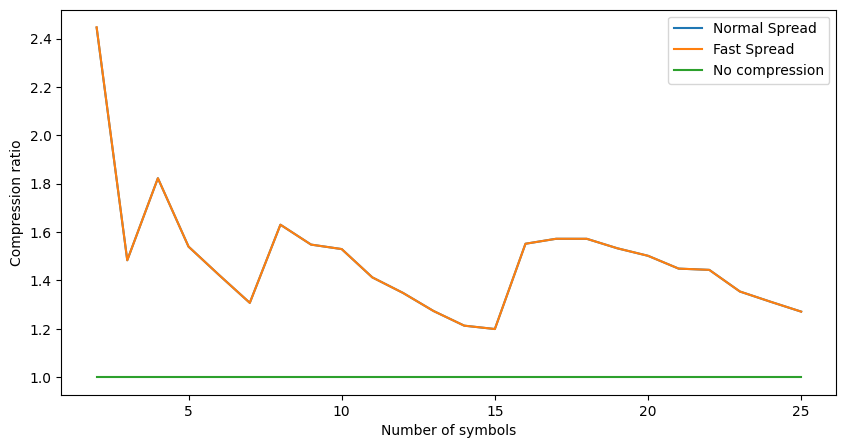

In [37]:
# plot results
plt.figure(figsize=(10,5))
plt.plot(n_symbols, avg_saved, label="Normal Spread")
plt.plot(n_symbols, avg_saved_fast, label="Fast Spread")
plt.plot(n_symbols, [1 for i in n_symbols], label="No compression")
plt.xlabel("Number of symbols")
plt.ylabel("Compression ratio")
plt.legend()
plt.show()

In [38]:
# Seeing how number of symbols affects the compression ratio
n_trials = 50
n_symbols = [i for i in range(2,26,1)]
avg_saved = []
avg_saved_fast = []
avg_time = []
avg_time_fast = []
alphabet_full = ["A", "B", "C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]

for n in n_symbols:
    print("Number of symbols:", n)
    alphabet = alphabet_full[:n]
    saved = 0
    saved_fast = 0
    time_taken = 0
    time_taken_fast = 0
    
    for i in range(n_trials):
        freq = generate_normal_distribution_bins(len(alphabet), 1000)
        c = Coder(sum(freq), alphabet, freq, fast= True)
        c_fast = Coder(sum(freq), alphabet, freq, fast= False)
        # encode a message
        msg = generate_random_string(alphabet, freq)
        msg_tmp = list(msg)

        time_start = time.time()
        out_tmp, sav = c.encode_decode(msg_tmp)
        out = "".join(out_tmp)
        time_end = time.time()
        time_taken += time_end - time_start

        time_start = time.time()
        out_tmp_fast, sav_fast = c_fast.encode_decode(msg_tmp)
        out_fast = "".join(out_tmp_fast)
        time_end = time.time()
        time_taken_fast += time_end - time_start

        saved += sav
        saved_fast += sav_fast
        if msg != out or msg != out_fast:
            print("Error")
            print(freq,msg)
            break

    avg_saved.append(saved/n_trials)
    avg_saved_fast.append(saved_fast/n_trials)
    avg_time.append(time_taken/n_trials)
    avg_time_fast.append(time_taken_fast/n_trials)
    
    # print("Normal Spread:", (saved/n_trials), time_taken/n_trials)
    # print("Fast Spread:",(saved_fast/n_trials), time_taken_fast/n_trials)

Number of symbols: 2
Number of symbols: 3
Number of symbols: 4
Number of symbols: 5
Number of symbols: 6
Number of symbols: 7
Number of symbols: 8
Number of symbols: 9
Number of symbols: 10
Number of symbols: 11
Number of symbols: 12
Number of symbols: 13
Number of symbols: 14
Number of symbols: 15
Number of symbols: 16
Number of symbols: 17
Number of symbols: 18
Number of symbols: 19
Number of symbols: 20
Number of symbols: 21
Number of symbols: 22
Number of symbols: 23
Number of symbols: 24
Number of symbols: 25


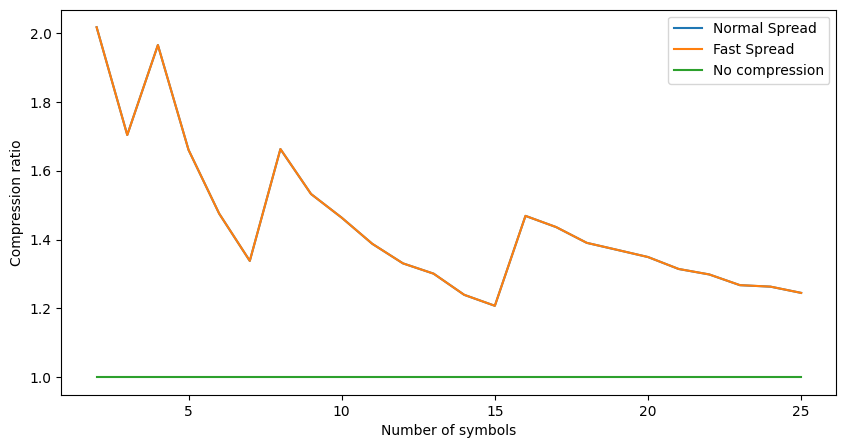

In [39]:
# plot results
plt.figure(figsize=(10,5))
plt.plot(n_symbols, avg_saved, label="Normal Spread")
plt.plot(n_symbols, avg_saved_fast, label="Fast Spread")
plt.plot(n_symbols, [1 for i in n_symbols], label="No compression")
plt.xlabel("Number of symbols")
plt.ylabel("Compression ratio")
plt.legend()
plt.show()